# Retrospective analysis of label errors in a computer vision pipeline

When screening our [ML pipeline for identifying product images](https://github.com/schelterlabs/arguseyes/blob/sigmod-demo/arguseyes/example_pipelines/mlinspect-computervision-sneakers.py) on Github with this [configuration](https://github.com/schelterlabs/arguseyes-example/blob/main/mlinspect-computervision-sneakers-labelerrors.yaml), ArgusEyes detects **label errors** in the input data of the pipeline. 

The screenshot shows the result of the [screening during the build triggered by a Github action](https://github.com/schelterlabs/arguseyes-example/actions/runs/3523396218/jobs/5907506876): There are **273 potentially mislabeled samples in the train set**.

In the following, we show how to **leverage ArgusEyes to retrospectively analyze the pipeline run** (based on metadata and captured data artifacts), and **confirm and identify the mislabeled images**.

![label-error-screening-via-a-github-action](github-action-labelerror-screening.png)

### Load the metadata and artifacts from the original run of the pipeline

ArgusEyes needs the run id from the mlflow run where ArgusEyes stored the metadata and artifacts. (Note we use a local run here for demo purposes).

In [24]:
from arguseyes.retrospective import PipelineRun, LabelErrorsRetrospective

In [25]:
run_id = '55bd2b33ff45444593a0dd2cafdcc469'

run = PipelineRun(run_id=run_id)

### Interactively explore the dataflow plan and data of the pipeline run

We can view a dataflow plan of the pipeline, which highlights the input datasets, as well as the features and labels for the train and test data computed by the pipeline. We can interactively explore the pipeline data. Clicking on the pink data vertices provides us with details about the corresponding data.

In [26]:
run.explore_data()

# Pipeline Data Explorer

## Retrospective analysis of the label errors issue

ArgusEyes allows us to instantiate a special `LabelErrorsRetrospective`, which helps us find potentially mislabeled examples in the pipeline's training data

In [6]:
retrospective = LabelErrorsRetrospective(run)

## Data valuation with Shapley values

We can load a "refined" version of our the pipeline's main input (the product images), which contains the Shapley value for each tuple. This value indicates how "valuable" a particular tuple has been for the convolutional neural network trained by the pipeline.

Negative Shapley values denote that a tuple hurts the accuracy of the neural network and is a strong indication that this tuple is potentially mislabeled.

In [7]:
images_with_shapley_values = retrospective.load_entity_table_with_shapley_values()
images_with_shapley_values

,image,category_id,__shapley_value
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 166, 158, ...",1,0.000000
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 32,...",8,0.000000
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 153, 114, 111...",1,0.000000
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 78, 1, 0, 2...",6,0.000000
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,0.000000
...,...,...,...
4795,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,0.000000
4796,"[0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 70, 222, 201...",6,0.000000
4797,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 92, 146, ...",4,0.000000
4798,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0.000785


### Count the number of tuples with negative Shapley values in the raw input

In [8]:
len(images_with_shapley_values[images_with_shapley_values['__shapley_value'] < 0])

273

### Join product category information to analyze the label errors per category

ArgusEyes allows us to load the original product categories input data and join it with the valued input tuples.

In [9]:
categories, _ = run.load_input(2)
categories

,category_id,category_name
0,0,T-shirt/top
1,1,Trouser
2,2,Pullover
3,3,Dress
4,4,Coat
5,5,Sandal
6,6,Shirt
7,7,Sneaker
8,8,Bag
9,9,Ankle boot


In [14]:
images_with_shapley_values = images_with_shapley_values.merge(categories, on='category_id')

### Analyze the distribution of potential label errors over the product categories

We find that the label errors occur in both the sneaker and ankle boot images with roughly the same frequency

In [16]:
potentially_mislabeled = images_with_shapley_values[images_with_shapley_values['__shapley_value'] < 0]
potentially_mislabeled.category_name.value_counts()

Sneaker       139
Ankle boot    134
Name: category_name, dtype: int64

### Visually confirm the label errors

Finally, we visually inspect the images per category with the lowest Shapley values to confirm that they are indeed mislabeled. We write a helper function to plot product images.

In [17]:
def plot_worst_shapley(worst_images):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, len(worst_images))


    for index, axis in enumerate(ax):
        category = worst_images.iloc[index].category_name  
        value = worst_images.iloc[index]['__shapley_value']
        axis.imshow(worst_images.iloc[index].image.reshape(28, 28, 1), cmap='gray')
        axis.set_title(f'Label:\n{category}\n\nShapley\nvalue:\n{value:.5f}')
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()    
    fig.set_size_inches(8, 4)
    plt.show()

### Ankleboots mislabeled as sneakers!

When analyzing the seven sneaker images with the lowest Shapley values, we find that they are actually pictures of Ankleboots that have been accidentally labeled as sneakers.

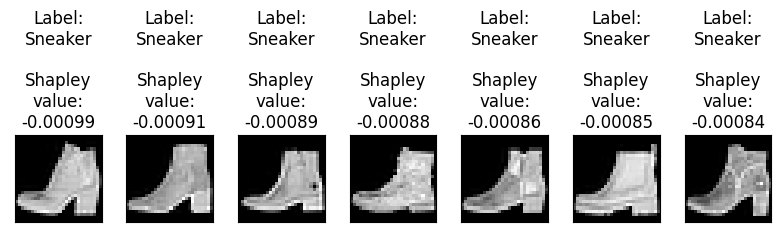

In [21]:
sneakers = potentially_mislabeled[potentially_mislabeled.category_name=='Sneaker']
worst_sneakers = sneakers.sort_values(by=['__shapley_value'])[:7]
plot_worst_shapley(worst_sneakers)

### Sneakers mislabeled as ankleboots!

When analyzing the seven ankle boot images with the lowest Shapley values, we find that they are actually pictures of sneakers that have been accidentally labeled as ankle boots.

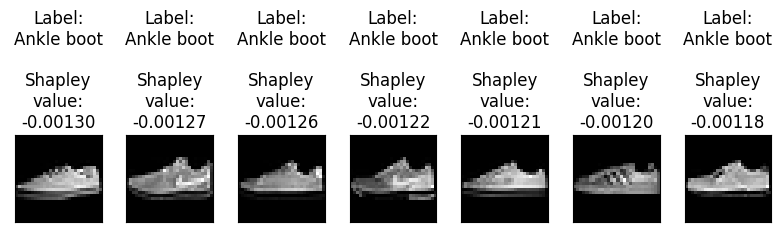

In [22]:
ankleboots = potentially_mislabeled[potentially_mislabeled.category_name=='Ankle boot']
worst_ankleboots = ankleboots.sort_values(by=['__shapley_value'])[:7]
plot_worst_shapley(worst_ankleboots)

### Fixing the pipeline

In order to fix the pipeline and improve its prediction performance, we have to either (a) exclude the mislabeled images from the input, or (b) manually fix the labels for them. Rerunning the pipeline with a cleaned input dataset results in a higher classification accuracy. 
